# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import plotly.express as px
import random

import torchvision.utils as vutils

In [2]:
import deeplake

/opt/anaconda3/lib/python3.8/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.4.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


# Data loading

In [3]:
ds = deeplake.load('hub://activeloop/wiki-art')

-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wiki-art



\

hub://activeloop/wiki-art loaded successfully.



In [4]:
class_names = np.unique(ds.labels.data()['text'])
class_names

array(['abstract_expressionism', 'action_painting', 'analytical_cubism',
       'art_nouveau_modern', 'baroque', 'color_field_painting',
       'contemporary_realism', 'cubism', 'early_renaissance',
       'expressionism', 'fauvism', 'high_renaissance', 'impressionism',
       'mannerism_late_renaissance', 'minimalism',
       'naive_art_primitivism', 'new_realism', 'northern_renaissance',
       'pointillism', 'pop_art', 'post_impressionism', 'realism',
       'rococo', 'romanticism', 'symbolism', 'synthetic_cubism',
       'ukiyo_e'], dtype='<U26')

In [5]:
IMG_SIZE=64

In [6]:
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    # transforms.CenterCrop(IMG_SIZE*0.5),
    # transforms.RandomCrop(IMG_SIZE*0.75, padding=2),
    # transforms.RandomHorizontalFlip(),   
    
    # ^ not so simple. uncommenting these sometimes leads to visualization errors (transformation fails idk)
    # also uncommenting makes the visualizations weird as you can imagine
    
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # ^ this maps the range [0, 1] into [-1, 1], because the minimum value 0 will be converted to 
    # (0-0.5)/0.5 = -1 and 1 -> (1-0.5)/0.5 = 1
    # this was used in the example I'm following
    
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # ^ another option. i.e. for the 1st channel we have mean = 0.485, std = 0.229, etc.
    # these avlues are calculated from ImageNet, so they are standard practice. 
    # you can calculate the new mean and std on your training data but otherwise using the Imagenet pretrained 
    # model with its own mean and std is recommended. 
])

## Dataset

In [7]:
# class LimitDataset(data.Dataset):
#     def __init__(self, dataset, n):
#         self.dataset = dataset
#         self.n = n

#     def __len__(self):
#         return self.n

#     def __getitem__(self, i):
#         return self.dataset[i]
    
# adding n limits size of dataset
class PaintingDataset(Dataset):
    def __init__(self, ds, n, transform = None): # added n
        self.ds = ds
        self.transform = transform
        self.n = n

    def __len__(self):
        return self.n # make default self.ds
        # return len(self.ds)
    
    def __getitem__(self, idx):
        image = self.ds.images[idx].numpy()
        label = self.ds.labels[idx].numpy(fetch_chunks = True).astype(np.int32)
        # When loading data sequentially, or when randomly loading samples from a tensor that fits 
        # into the cache (such as class_labels) it is recommended to set fetch_chunks = True. 
        # This increases the data loading speed by avoiding separate requests for each individual sample.
        # This is not recommended when randomly loading large tensors, because the data is deleted from the 
        # cache before adjacent samples from a chunk are used.

        if self.transform is not None:
            image = self.transform(image)

        sample = {"images": image, "labels": label}

        return sample

# Tutorial

In [8]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [9]:
# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


subset_size = 5000

In [10]:
# added to updated - change to subset of previous cell
dataset = PaintingDataset(ds,subset_size, transform = tform)
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)




In [11]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


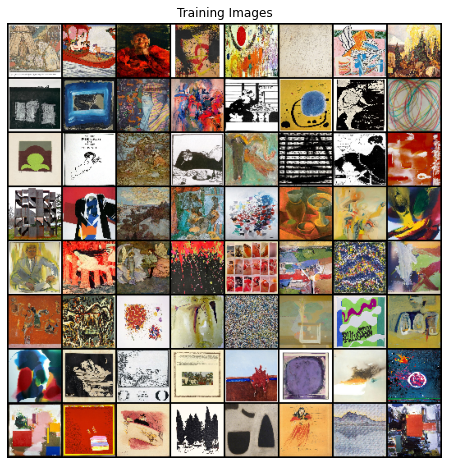

In [12]:

# Plot some training images
real_batch = next(iter(dataloader)) # uncomment when necessary
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
# had to update because tutorial doesn't work - takes a long time to run
plt.imshow(np.transpose(vutils.make_grid(list(real_batch.values())[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [193]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [194]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [195]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [196]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [181]:
print(ndf)

64


In [197]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [198]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [201]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


In [202]:
# Training Loop
num_epochs = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        print(i)
        print("discriminator gradient finished")
        # Format batch

#         real_cpu = list(real_batch.values())[0].to(device)
        real_cpu = list(data.values())[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        
        print("generator gradient finished")
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
        
# took like 3 minutes with 500, 2 epochs, 64 batch size
# now trying with 1000, 5 epochs, 64 batch size

# 100% accuracy after 2 steps, decrease epoch size, decrease step size, maybe decrease the overall szie again to test

# 1000 dataset size, 10 epochs, 64 batch size

# dataset size

Starting Training Loop...
0
discriminator gradient finished
generator gradient finished
[0/5][0/79]	Loss_D: 1.3793	Loss_G: 6.2015	D(x): 0.5924	D(G(z)): 0.4741 / 0.0027
1
discriminator gradient finished
generator gradient finished
2
discriminator gradient finished
generator gradient finished
3
discriminator gradient finished
generator gradient finished
4
discriminator gradient finished
generator gradient finished
5
discriminator gradient finished
generator gradient finished
6
discriminator gradient finished
generator gradient finished
7
discriminator gradient finished
generator gradient finished
8
discriminator gradient finished
generator gradient finished
9
discriminator gradient finished
generator gradient finished
10
discriminator gradient finished
generator gradient finished
11
discriminator gradient finished
generator gradient finished
12
discriminator gradient finished
generator gradient finished
13
discriminator gradient finished
generator gradient finished
14
discriminator gradi

/opt/anaconda3/lib/python3.8/site-packages/deeplake/util/warnings.py:7: UserWarning: Encountered connection error, retry 1 out of 5
  warnings.warn(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/deeplake/util/warnings.py:7: UserWarning: Connection re-established after 1 retry.
  warnings.warn(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.tra

30
discriminator gradient finished
generator gradient finished


KeyboardInterrupt: 

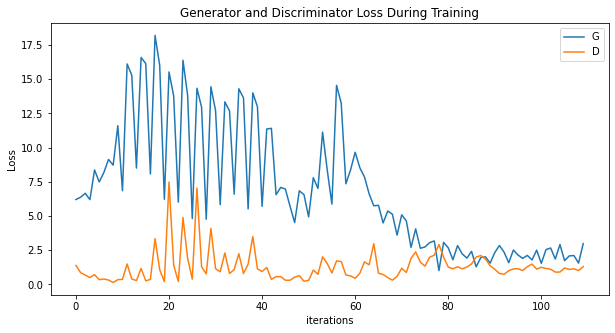

In [203]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [204]:
img_list

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4740,  ..., 0.5411, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4808,  ..., 0.5216, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4740,  ..., 0.5411, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.4808,  ..., 0.5216, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.4740,  ...,

In [207]:
len(img_list)

1

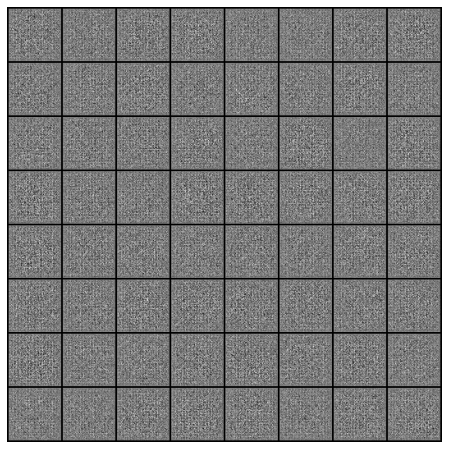

In [206]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


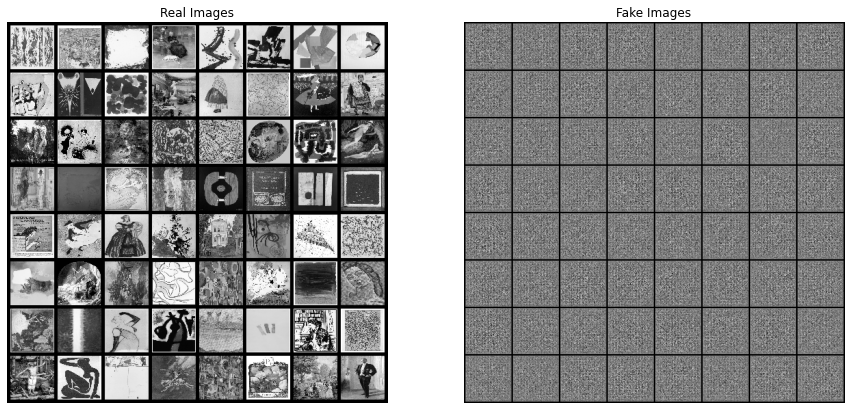

In [208]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(list(real_batch.values())[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


# Part of DGCAN Model from Github

In [40]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


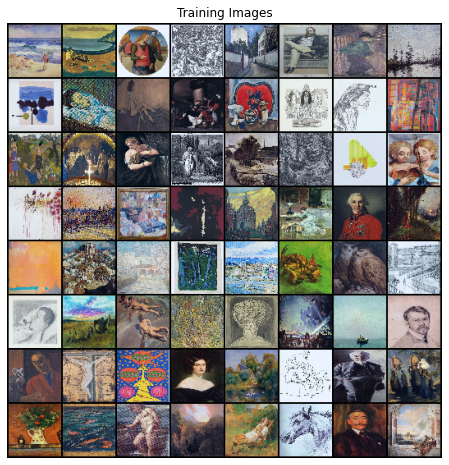

In [70]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(list(real_batch.values())[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [81]:
# Create the generator
netG = torch.Generator(device=device) # how does ngpu impact it?


In [82]:
netG.apply(weights_init)

# WeightedRandomSampler

# Print the model
print(netG)

AttributeError: 'torch._C.Generator' object has no attribute 'apply'

# Visualization and exploration

### i) of a single image

In [33]:
def plot_image(viz_idx):
    plt.figure(figsize=(8, 6))
    viz_img = dataset[viz_idx]['images']
    viz_img = invTrans(viz_img) # reverts image normalizations for display purposes
    viz_img = np.transpose(viz_img.cpu(), (1,2,0))
    plt.imshow(viz_img)
    plt.xlabel(ds.labels.data()['text'][viz_idx])

/opt/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


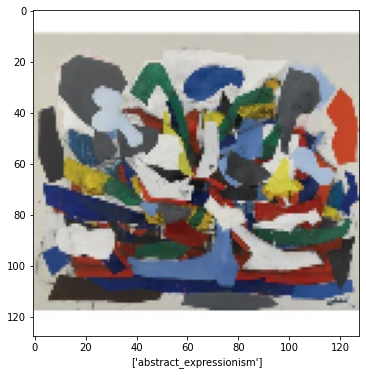

In [14]:
plot_image(2023)

### ii) of 8 images

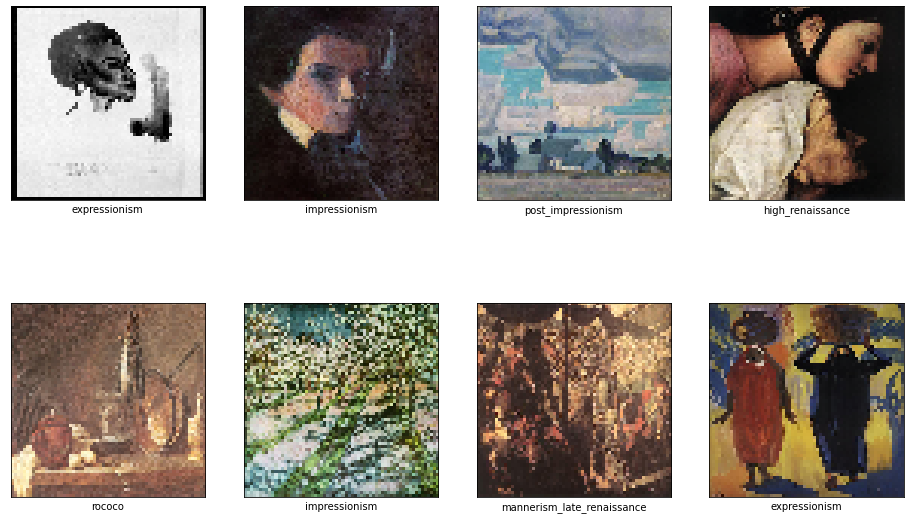

In [35]:
# can be slow
plt.figure(figsize=(16,10))
plt.title('Training Images')

images, labels = next(iter(dataloader)).values()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = invTrans(images[i]) # reverts image normalizations for display purposes  
    image = np.transpose(image.cpu(), (1,2,0))
    plt.imshow(image)
    plt.xlabel(class_names[labels[i]])
plt.show()

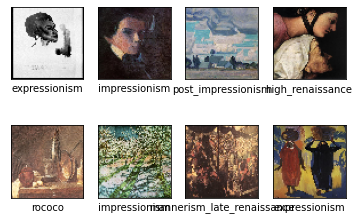

In [37]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = invTrans(images[i]) # reverts image normalizations for display purposes  
    image = np.transpose(image.cpu(), (1,2,0))
    plt.imshow(image)
    plt.xlabel(class_names[labels[i]])
plt.show()

## EDA

In [16]:
class_names

array(['abstract_expressionism', 'action_painting', 'analytical_cubism',
       'art_nouveau_modern', 'baroque', 'color_field_painting',
       'contemporary_realism', 'cubism', 'early_renaissance',
       'expressionism', 'fauvism', 'high_renaissance', 'impressionism',
       'mannerism_late_renaissance', 'minimalism',
       'naive_art_primitivism', 'new_realism', 'northern_renaissance',
       'pointillism', 'pop_art', 'post_impressionism', 'realism',
       'rococo', 'romanticism', 'symbolism', 'synthetic_cubism',
       'ukiyo_e'], dtype='<U26')

In [17]:
from collections import Counter

styles_int = [x[0] for x in ds.labels.data()['value']]
counter = dict(Counter(styles_int))
counter = {class_names[key]: val for key,val in counter.items()}
counter

{'abstract_expressionism': 2782,
 'action_painting': 98,
 'analytical_cubism': 110,
 'art_nouveau_modern': 4328,
 'baroque': 4241,
 'color_field_painting': 1615,
 'contemporary_realism': 481,
 'cubism': 2235,
 'early_renaissance': 1391,
 'expressionism': 6736,
 'fauvism': 934,
 'high_renaissance': 1343,
 'impressionism': 13060,
 'mannerism_late_renaissance': 1279,
 'minimalism': 1337,
 'naive_art_primitivism': 2405,
 'new_realism': 314,
 'northern_renaissance': 2550,
 'pointillism': 513,
 'pop_art': 1483,
 'post_impressionism': 6451,
 'realism': 10733,
 'rococo': 2089,
 'romanticism': 7015,
 'symbolism': 4527,
 'synthetic_cubism': 216,
 'ukiyo_e': 1167}

In [18]:
styles_df = pd.DataFrame({'style': counter.keys(), 'count': counter.values()})
styles_df.head()

,style,count
0,"(abstract_expressionism, action_painting, anal...","(2782, 98, 110, 4328, 4241, 1615, 481, 2235, 1..."
1,"(abstract_expressionism, action_painting, anal...","(2782, 98, 110, 4328, 4241, 1615, 481, 2235, 1..."
2,"(abstract_expressionism, action_painting, anal...","(2782, 98, 110, 4328, 4241, 1615, 481, 2235, 1..."
3,"(abstract_expressionism, action_painting, anal...","(2782, 98, 110, 4328, 4241, 1615, 481, 2235, 1..."
4,"(abstract_expressionism, action_painting, anal...","(2782, 98, 110, 4328, 4241, 1615, 481, 2235, 1..."


In [19]:
fig = px.pie(styles_df, values='count', names='style', 
             hover_name='style', 
             title='Distribution of Paintings by Art Movement')
fig.show()

SystemError: <built-in method __deepcopy__ of numpy.ndarray object at 0x7fc580b91570> returned a result with an error set

### in prep for streamlit: interactive painting retrieval

Proposal: User can select an art movement, and the app retrieves a random painting from that movement (just for fun)

In [28]:
class_names

array(['abstract_expressionism', 'action_painting', 'analytical_cubism',
       'art_nouveau_modern', 'baroque', 'color_field_painting',
       'contemporary_realism', 'cubism', 'early_renaissance',
       'expressionism', 'fauvism', 'high_renaissance', 'impressionism',
       'mannerism_late_renaissance', 'minimalism',
       'naive_art_primitivism', 'new_realism', 'northern_renaissance',
       'pointillism', 'pop_art', 'post_impressionism', 'realism',
       'rococo', 'romanticism', 'symbolism', 'synthetic_cubism',
       'ukiyo_e'], dtype='<U26')

In [57]:
movement = 'cubism'
style_idx = np.where(class_names == movement)[0][0]
# np.where weirdly returns a tuple of (array([num1, num2, etc.]),) for some reason so we take [0], then there's
# only one match so [0] again
style_idx

7

In [58]:
styles_int = [x[0] for x in ds.labels.data()['value']] # returns 0, 0, 5, 16, etc. the style for each painting
len(styles_int) == len(dataset)

True

In [70]:
match_idx = np.where(np.array(styles_int) == style_idx)[0] # indices of paintings with the indicated style
match_idx

array([13655, 13656, 13657, ..., 15887, 15888, 15889])

In [38]:
idx = int(random.choice(match_idx))
plot_image(idx)

NameError: name 'match_idx' is not defined